### Imports

In [9]:
!ipython kernel install --user --name=env

Installed kernelspec env in /home/trhiana/.local/share/jupyter/kernels/env


In [2]:
!python3.9 -m pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
  Using cached pip-23.1-py3-none-any.whl (2.1 MB)


In [5]:
!python -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Using cached pandas-1.1.5.tar.gz (5.2 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: Could not find a version that satisfies the requirement torch~=1.7.0 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0)
ERROR: No matching distribution found for torch~=1.7.0


In [1]:
import sys
import json
import matplotlib.pyplot as plt
import numpy as np

### Local imports

In [2]:
!python -m pip install context_printer

Defaulting to user installation because normal site-packages is not writeable


In [2]:
sys.path.insert(0,'src/')
from src.metrics import BinaryClassificationResult
from src.print_util import print_rates

### Functions

In [3]:
# Get the results of a single experiment, summed over the reruns and the configurations
def get_results_non_federated(all_results):
    result = BinaryClassificationResult()
    for configuration, configuration_results in all_results.items():      
        # Run can be a random rerun (when testing) or a fold (when grid searching)
        for run, run_result in enumerate(configuration_results):
            result += BinaryClassificationResult(*run_result.values())

    return result

In [4]:
# Get the results for each federation round of a single experiment, summed over the reruns and the configurations
def get_results_per_round(all_results):
    results_per_round = []
    for configuration, configuration_results in all_results.items():      
        # Run is the current random rerun
        for run, run_results in enumerate(configuration_results):
            for federation_round, round_results in enumerate(run_results):
                if federation_round >= len(results_per_round):
                    results_per_round.append(BinaryClassificationResult())  
                results_per_round[federation_round] += BinaryClassificationResult(*round_results.values())
                
    return results_per_round

In [5]:
# Get the results of a single experiment, summed over the reruns and the configurations
def get_thresholds_federated(all_thresholds):
    thresholds_sum = []
    n = 0
    for configuration, configuration_thresholds in all_thresholds.items():
        # Run can be a random rerun (when testing) or a fold (when grid searching)
        for run_thresholds in configuration_thresholds:
            n += 1
            for federation_round, round_threshold in enumerate(run_thresholds):
                if federation_round >= len(thresholds_sum):
                    thresholds_sum.append(0.)  
                thresholds_sum[federation_round] += round_threshold
    thresholds = [s / n for s in thresholds_sum]
                
    return thresholds

In [6]:
def plot_federated_tpr_tnr(results_to_plot, title=''):
    fig, ax1 = plt.subplots(figsize=(12, 5))
    ax1.set_xlabel('Federation round')

    color = 'blue'
    ax1.set_title(title)
    ax1.set_ylabel('TPR', color=color)
    ax1.plot([result.tpr() for result in results_to_plot], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.ticklabel_format(useOffset=False)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'red'
    ax2.set_ylabel('TNR', color=color)
    ax2.plot([result.tnr() for result in results_to_plot], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()

In [7]:
def plot_federated_acc(results_to_plot, title='', multi_epoch=True, save=False):
    fig, ax = plt.subplots(figsize=(12, 5))
    if multi_epoch:
        ax.set_xlabel('Federation round')
    else:
        ax.set_xlabel('Epoch')

    color = 'green'
    ax.set_title(title)
    ax.set_ylabel('Accuracy', color=color)
    ax.plot([result.acc() for result in results_to_plot], color=color)
    ax.tick_params(axis='y', labelcolor=color)
    ax.ticklabel_format(useOffset=False)
    ax.grid()
    plt.show()
    if save:
        fig.savefig('federated_accuracy' + ('_multi_epoch' if multi_epoch else '_mini_batch') + '.pdf', bbox_inches='tight')

In [8]:
def plot_global_thresholds(thresholds, title='', multi_epoch=True, save=False):
    fig, ax = plt.subplots(figsize=(6, 5))
    color = 'purple'
    ax.set_title(title)
    ax.set_ylabel('Threshold', color=color)
    
    if multi_epoch:
        ax.set_xlabel('Federation round')
        ax.plot(thresholds, color=color)
    else:
        ax.set_xlabel('Epoch')
        ax.set_xticks(np.arange(0, 120, step=10))
        ax.plot(np.arange(0,120, step=10), thresholds, color=color)

    ax.tick_params(axis='y', labelcolor=color)
    ax.ticklabel_format(useOffset=False)
    ax.grid()
    ax.set_ylim(ymin=0)
    plt.show()
    if save:
        fig.savefig('thresholds' + ('_multi_epoch' if multi_epoch else '_mini_batch') + '.pdf', bbox_inches='tight')

In [9]:
def percentage_str(value, bf=False):
    s = '{:.2f}\\%'.format(value * 100)
    if bf:
        s = '\\textbf{' + s + '}'
    return s

In [10]:
def print_rates_latex(results):
    print('Accuracy:\t' + percentage_str(results.acc(), bf=True))
    print('TPR:\t\t' + percentage_str(results.tpr()))
    print('TNR:\t\t' + percentage_str(results.tnr()))

In [11]:
def print_rates_latex2(results):
    print('Accuracy:\t' + percentage_str(results.acc()))
    print('TPR:\t\t' + percentage_str(results.tpr()))
    print('TNR:\t\t' + percentage_str(results.tnr()))
    print('F1-Score:\t' + percentage_str(results.f1()))

In [12]:
def get_average_threshold_non_federated(thresholds_dict):
    threshold_sum = 0.
    counter = 0
    for configuration, configuration_results in thresholds_dict.items():      
        # Run can be a random rerun (when testing) or a fold (when grid searching)
        for run, run_result in enumerate(configuration_results):
            counter += 1
            threshold_sum += run_result[0]
    return threshold_sum / counter

### Non-federated

In [13]:
path_test = 'test_results/decentralized_classifier/0,5 2rr/'

with open(path_test + 'local_results.json') as json_file:
    test_local_results = json.load(json_file)
    
with open(path_test + 'new_devices_results.json') as json_file:
    test_new_results = json.load(json_file)
    
local_result = get_results_non_federated(test_local_results)
new_result = get_results_non_federated(test_new_results)
print('Local result:')
print_rates_latex(local_result)
print()

print('New result:')
print_rates_latex(new_result)

Local result:
Accuracy:	\textbf{99.79\%}
TPR:		99.98\%
TNR:		97.62\%

New result:
Accuracy:	\textbf{99.16\%}
TPR:		99.73\%
TNR:		92.50\%


### Threshold

In [14]:
path_test = 'test_results/decentralized_autoencoder/0,5 2rr 0,95quantile/'

with open(path_test + 'thresholds.json') as json_file:
    thresholds = json.load(json_file)

avg_threshold = get_average_threshold_non_federated(thresholds)
print(avg_threshold)

0.0007051476309748574


### Federated

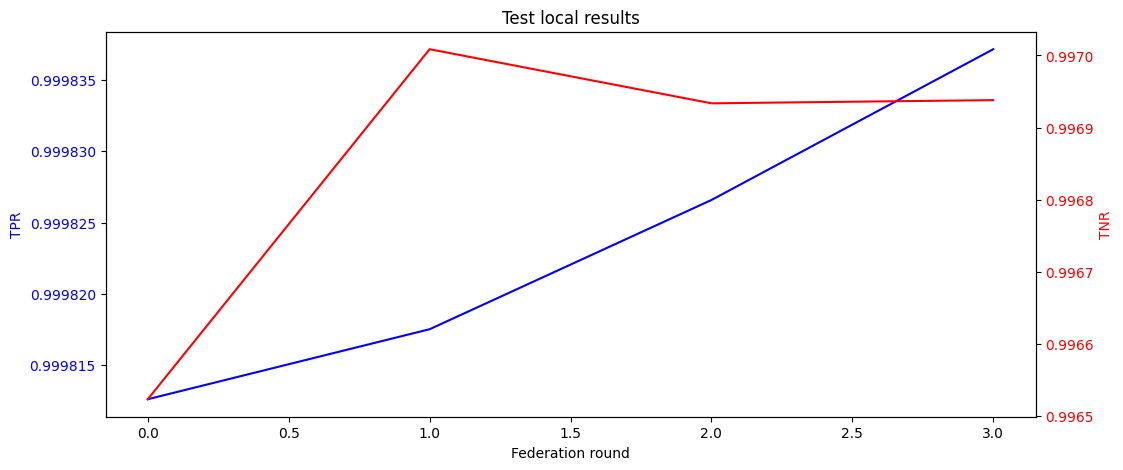

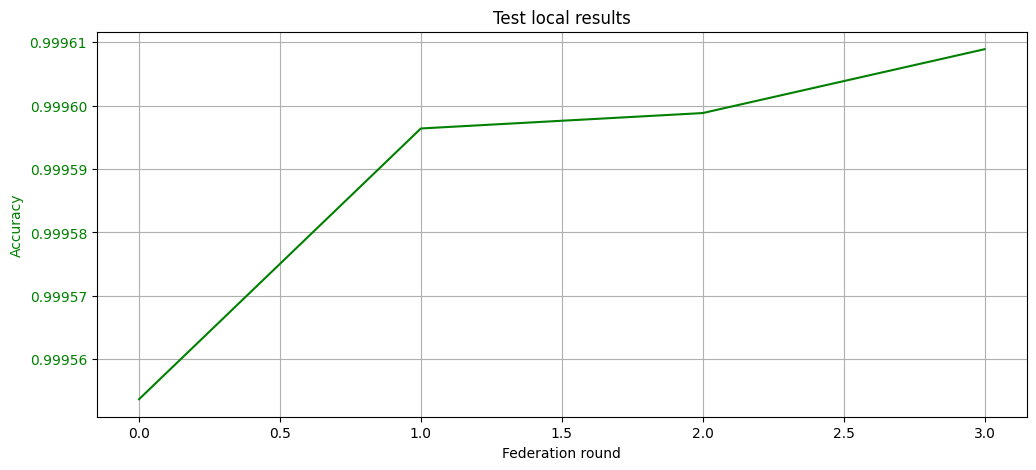

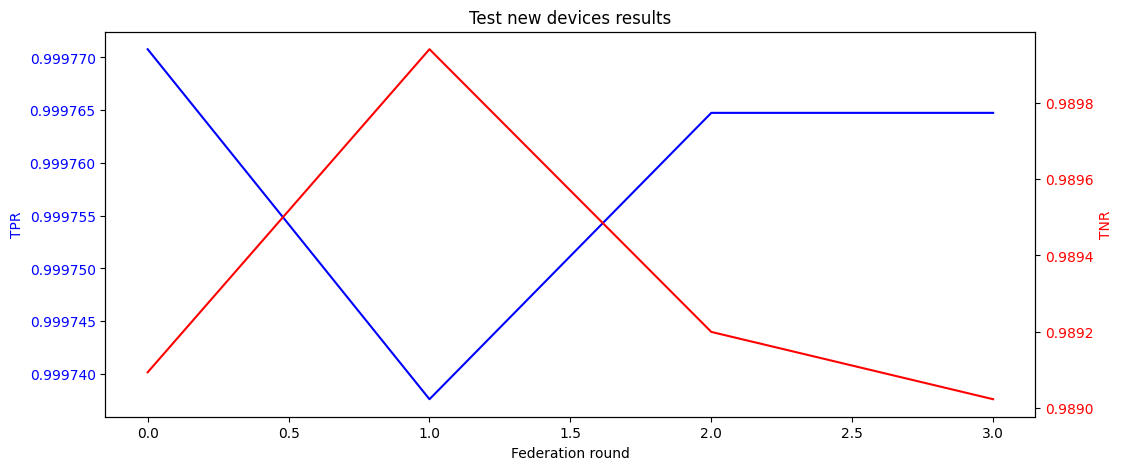

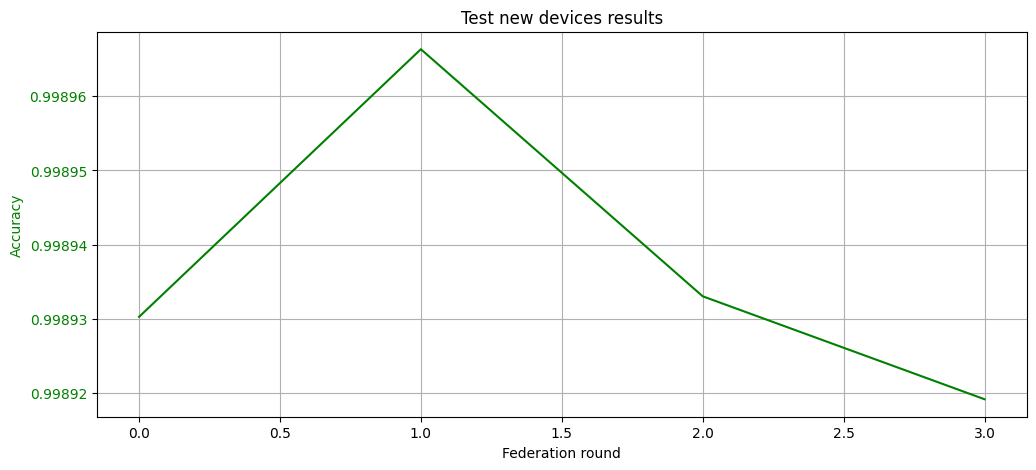

Local result at last round:
Accuracy:	99.96\%
TPR:		99.98\%
TNR:		99.69\%
F1-Score:	99.98\%

New result at last round:
Accuracy:	99.89\%
TPR:		99.98\%
TNR:		98.90\%
F1-Score:	99.94\%


In [16]:
# TODO: rename the x-axis as epoch in fedsgd and make it start at 1 in both cases

path_test = 'test_results/decentralized_classifier_fedsgd/run_0/'

with open(path_test + 'local_results.json') as json_file:
    test_local_results = json.load(json_file)
    
with open(path_test + 'new_devices_results.json') as json_file:
    test_new_results = json.load(json_file)
    
local_results_per_round = get_results_per_round(test_local_results)
plot_federated_tpr_tnr(local_results_per_round, title='Test local results')
plot_federated_acc(local_results_per_round, title='Test local results', multi_epoch=True)

new_results_per_round = get_results_per_round(test_new_results)
plot_federated_tpr_tnr(new_results_per_round, title='Test new devices results')
plot_federated_acc(new_results_per_round, title='Test new devices results')

print('Local result at last round:')
print_rates_latex2(local_results_per_round[-1])
print()

print('New result at last round:')
print_rates_latex2(new_results_per_round[-1])

In [17]:
def plot_federated_acc_2(res1, res2, res3, multi_epoch=True, save=False):
    fig, ax = plt.subplots(figsize=(6, 5))
    color1 = 'red'
    color2 = 'green'
    color3 = 'blue'
    
    ticks = list(np.arange(1, len(res1)+1))   
    
    if multi_epoch:
        ax.set_xlabel('Federation round')
        ax.set_xticks(ticks[::2])
    else:
        ax.set_xlabel('Epoch')
        ax.set_xticks(ticks)
    
    ax.grid()
        
    ax.set_ylabel('Accuracy')
    ax.plot(ticks,[result.acc() for result in res1], color=color1, label='7.87% benign')
    ax.plot(ticks,[result.acc() for result in res2], color=color2, label='50% benign')
    ax.plot(ticks,[result.acc() for result in res3], color=color3, label='95% benign')
    
    ax.hlines(0.9996, xmin=ticks[0], xmax=ticks[-1], color=color1, linestyles='dotted', label='7.87% benign (centralized)')
    ax.hlines(0.9991, xmin=ticks[0], xmax=ticks[-1], color=color2, linestyles='dotted', label='50% benign (centralized)')
    ax.hlines(0.9993, xmin=ticks[0], xmax=ticks[-1], color=color3, linestyles='dotted', label='95% benign (centralized)')

    
    ax.tick_params(axis='y')
    ax.ticklabel_format(useOffset=False)
    ax.legend()
    
    
    ax.set_ylim(0.992, 0.9997)
    ax.set_xlim(ticks[0], ticks[-1])
    plt.show()
    if save:
        fig.savefig('federated_accuracy' + ('_multi_epoch' if multi_epoch else '_mini_batch') + '.pdf', bbox_inches='tight')

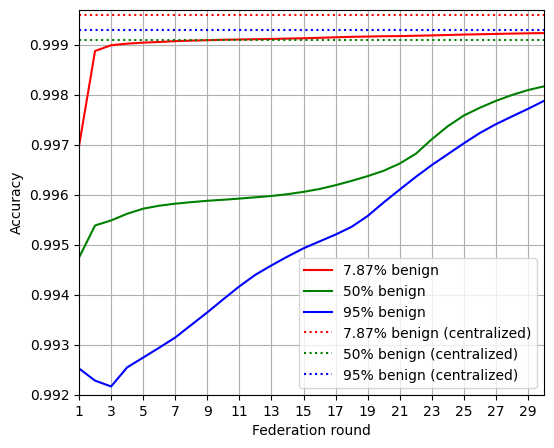

In [24]:
path_1 = 'test_results/decentralized_classifier_fedavg/0,0787 5rr/'
path_2 = 'test_results/decentralized_classifier_fedavg/0,5 5rr/'
path_3 = 'test_results/decentralized_classifier_fedavg/0,95 5rr/'

# path_1 = 'test_results/decentralized_classifier_fedsgd/NO_ATTACK/0,0787 5rr/'
# path_2 = 'test_results/decentralized_classifier_fedsgd/NO_ATTACK/0,5 5rr/'
# path_3 = 'test_results/decentralized_classifier_fedsgd/NO_ATTACK/0,95 5rr/'


with open(path_1 + 'local_results.json') as json_file:
    all_results_1 = json.load(json_file)

with open(path_2 + 'local_results.json') as json_file:
    all_results_2 = json.load(json_file)
    
with open(path_3 + 'local_results.json') as json_file:
    all_results_3 = json.load(json_file)
    
res1 = get_results_per_round(all_results_1)
res2 = get_results_per_round(all_results_2)
res3 = get_results_per_round(all_results_3)

plot_federated_acc_2(res1, res2, res3, multi_epoch=True, save=True)

In [25]:
def plot_global_thresholds_2(thresholds_1, multi_epoch=True, save=False):
    fig, ax = plt.subplots(figsize=(6, 5))
    color_1 = 'purple'
    color_2 = 'green'
    ax.set_ylabel('Threshold')
    ax.set_ylim(0, 0.0105)
    
    
    
    if multi_epoch:
        ticks = list(np.arange(1, len(thresholds_1)+1))
        ax.set_xlabel('Federation round')
        ax.set_xticks(ticks[::2])
    else:
        ax.set_xlabel('Epoch')
        ticks = list(np.arange(1, len(thresholds_1)*10+1, step=10))
        ax.set_xticks(ticks)
                
    
    if multi_epoch:
        label = "Multi-epoch averaging"
    else:
        label = "Mini-batch averaging"
    ax.plot(ticks, thresholds_1, color=color_1, label=label)
    
    ax.hlines(0.001566670167570313, xmin=ticks[0], xmax=ticks[-1], color=color_1, linestyles='dotted', label='Centralized')

    ax.set_xlim(ticks[0], ticks[-1])
    ax.tick_params(axis='y')
    ax.ticklabel_format(useOffset=False)
    ax.legend()
    ax.grid()
    plt.show()
    if save:
        fig.savefig('thresholds' + ('_multi_epoch' if multi_epoch else '_mini_batch') + '.pdf', bbox_inches='tight')

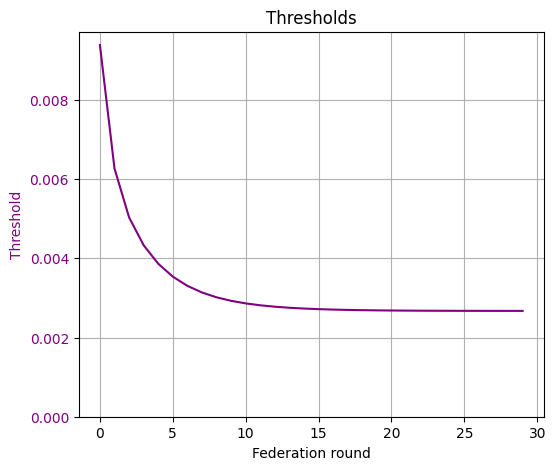

In [29]:
path_1 = 'test_results/decentralized_autoencoder_fedavg/0,5 5rr mean+std/'
with open(path_1 + 'thresholds.json') as json_file:
    all_thresholds_1 = json.load(json_file)


global_thresholds_1 = get_thresholds_federated(all_thresholds_1)
plot_global_thresholds(global_thresholds_1, 'Thresholds', multi_epoch=True, save=True)

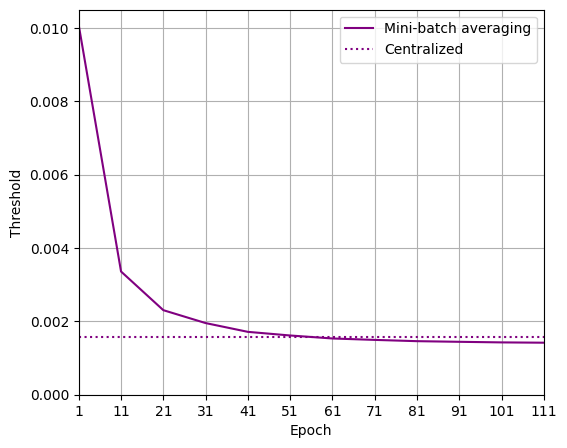

In [30]:
path_1 = 'test_results/decentralized_autoencoder_fedsgd/0,5 5rr mean+std/'

with open(path_1 + 'thresholds.json') as json_file:
    all_thresholds_1 = json.load(json_file)
    
global_thresholds_1 = get_thresholds_federated(all_thresholds_1)
plot_global_thresholds_2(global_thresholds_1, multi_epoch=False, save=True)

### Adversarial plots

In [31]:
b1 = BinaryClassificationResult(tp=45, tn=30, fp=20, fn=5)
b2 = BinaryClassificationResult(tp=3, tn=38, fp=12, fn=47)

In [32]:
b1.precision()

0.6923076923076923

In [33]:
b2.precision()

0.2

In [34]:
(b1+b2).precision()

0.6

In [35]:
(b1.precision() + b2.precision())/2

0.4461538461538461

In [36]:
def get_all_results(path):
    with open(path + 'local_results.json') as json_file:
        local_results = json.load(json_file)
    return local_results

In [37]:
def get_new_results(path):
    with open(path + 'new_devices_results.json') as json_file:
        new_results = json.load(json_file)
    return new_results

In [38]:
def get_min_score(all_results, score='f1', federated=True):
    min_score = 1.
    for configuration, configuration_results in all_results.items():      
        # Run is the current random rerun
        for run, run_results in enumerate(configuration_results):
            if federated:
                result = BinaryClassificationResult(**run_results[-1])
            else:
                result = BinaryClassificationResult(**run_results)
            current_score = getattr(result, score)()
            if current_score < min_score:
                min_score = current_score
                
    return min_score

In [39]:
def get_max_score(all_results, score='f1', federated=True):
    max_score = 0.
    for configuration, configuration_results in all_results.items():      
        # Run is the current random rerun
        for run, run_results in enumerate(configuration_results):
            if federated:
                result = BinaryClassificationResult(**run_results[-1])
            else:
                result = BinaryClassificationResult(**run_results)
            current_score = getattr(result, score)()
            if current_score > max_score:
                max_score = current_score
                
    return max_score

In [40]:
def get_mean_score(all_results, score='f1', federated=True):
    score_sum = 0.
    counter = 0
    for configuration, configuration_results in all_results.items():      
        # Run is the current random rerun
        for run, run_results in enumerate(configuration_results):
            if federated:
                result = BinaryClassificationResult(**run_results[-1])
            else:
                result = BinaryClassificationResult(**run_results)
            current_score = getattr(result, score)()
            score_sum += current_score
            counter += 1
                
    return score_sum / counter

In [41]:
def print_latex_f1_scores(base_path, end_path):
    avg_results = get_all_results(base_path + 'avg' + end_path)
    med_results = get_all_results(base_path + 'med' + end_path)
    tm1_results = get_all_results(base_path + 'tm1' + end_path)
    tm2_results = get_all_results(base_path + 'tm2' + end_path)
    tm2_2rs_results = get_all_results(base_path + 'tm2-2rs' + end_path)
    
    print('AVG:\t' + percentage_str(get_mean_score(avg_results)))
    print('MED:\t' + percentage_str(get_mean_score(med_results)))
    print('TM1:\t' + percentage_str(get_mean_score(tm1_results)))
    print('TM2:\t' + percentage_str(get_mean_score(tm2_results)))
    print('TM2-2RS:\t' + percentage_str(get_mean_score(tm2_2rs_results)))

In [42]:
def percentage_to_text(percentage, decimals=0):
#     text = "{:.2f}".format(proportion)
#     if text.startswith("0."):
#         return text[1:]
#     if text.startswith("-0."):
#         return "-" + text[2:]
    return ("{:."+repr(decimals)+"f}").format(percentage)

In [46]:
def plot_f1_scores(base_path, end_path, attack_str):
    fig, ax = plt.subplots(figsize=(12, 5))
#     ax.set_title('Average, min and max F1-Scores under the ' +  attack_str + ' attack')
    ax.set_ylabel('F1-Score (%)')
    ax.set_ylim(0, 100.)
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
#     plt.gca().spines['bottom'].set_visible(False)
    
    pos_x = 0
    colors = ['limegreen', 'gold', 'tab:orange', 'orangered']
    colors = ['#87d64b', '#fae243', '#f8961e', '#ff4d36']
    text_colors = ['#456e25', '#998a28', '#b06a13', '#b33424']
    
    aggs = ['avg', 'med', 'tm1', 'tm2', 'tm2-2rs']
    
    bar_width = 1.5
    sep = 1
    
    for agg in aggs:
        for f in [0, 1, 2, 3]:
            color = colors[f]
            text_color = text_colors[f]
            if f == 0:
                results = get_all_results('test_results/decentralized_classifier_fedsgd/NO_ATTACK/0,95 5rr 64bs ' + agg + '/')
            else:
                results = get_all_results(base_path + agg + ' vs ' + repr(f) + end_path)
            mean_f1 = get_mean_score(results) * 100
            if mean_f1 == 0.0:
                mean_f1_bar = 1
            else:
                mean_f1_bar = mean_f1
            min_f1 = get_min_score(results) * 100
            max_f1 = get_max_score(results) * 100
            
            yerr_up = max_f1 - mean_f1
            yerr_down = mean_f1 - min_f1
            
            if agg == 'avg':
                ax.bar(pos_x, height=mean_f1_bar, color=color, width=bar_width, lw=0.7, edgecolor='black', label='f='+repr(f))
            else:
                ax.bar(pos_x, height=mean_f1_bar, color=color, width=bar_width, lw=0.7, edgecolor='black') # yerr=[[yerr_down], [yerr_up]], capsize=11
                
            ax.errorbar(x=pos_x, y=mean_f1_bar, yerr=[[yerr_down], [yerr_up]],
                        capsize=6, color='black', elinewidth=0, lw=1.0, solid_capstyle='round')
            
            s = percentage_to_text(mean_f1)
            if len(s) == 1:
                text_x = pos_x - 0.2
            else:
                text_x = pos_x - 0.5
                
            ax.text(x=text_x, y=mean_f1_bar+1.2, s=s, fontsize='15.5', color=text_color)
            
            pos_x += bar_width
        pos_x += sep
        
    ticks = [(1.5 * bar_width) + (4 * bar_width + sep) * i  for i in range(0, 5)]
    
    ax.set_xticks(ticks)
    aggs = [agg.upper() for agg in aggs]
    ax.set_xticklabels(aggs)
    ax.legend(bbox_to_anchor=(1.12, 0.5), loc='right')
    plt.show()
    fig.savefig('f1_scores_' + '_'.join(attack_str.split(' ')) + '.pdf', bbox_inches='tight')

In [47]:
plt.rcParams.update({'font.size': 16.5})

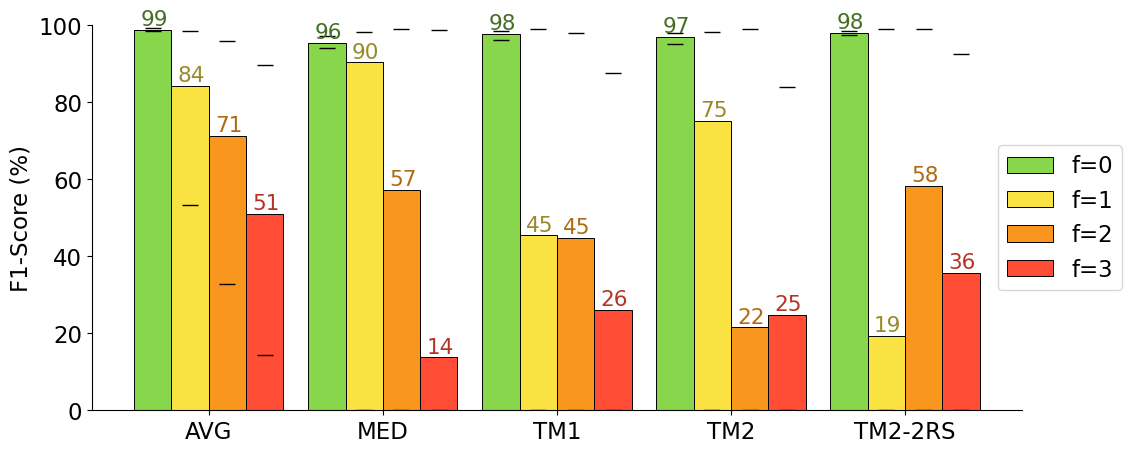

In [48]:
attack_folder = 'LABEL_FLIPPING'
attack_code = 'flipping/'
attack_name = 'all labels flipping'

# attack_folder = 'GRADIENT_FACTOR'
# attack_code = 'factor/'
# attack_name = 'gradient factor'

# attack_folder = 'CANCEL'
# attack_code = 'cancel/'
# attack_name = 'model cancelling'

plot_f1_scores('test_results/decentralized_classifier_fedsgd/' + attack_folder + '/', attack_code, attack_name)

In [52]:
def plot_error_rates(base_path, prop_folder):
    fig, ax = plt.subplots(figsize=(12, 5))
#     ax.set_title('Average, min and max F1-Scores under the ' +  attack_str + ' attack')
    ax.set_ylabel('Error rate (%)')
    ax.set_ylim(0, 1.8)
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
#     plt.gca().spines['bottom'].set_visible(False)
    
    pos_x = 0
    colors = ['#54cc5a', '#4287f5']
    text_colors = ['#367839', '#2f63b5']
    
    methods = ['naive', 'centralized', 'mini-batch', 'multi-epoch']
    
    bar_width = 0.5
    sep = 1
    
    for method in methods:
        if method == 'naive':
            current_path = base_path + 'decentralized_classifier/' + prop_folder + '/'
        elif method == 'mini-batch':
            current_path = base_path + 'decentralized_classifier_fedsgd/' + prop_folder + '/'
        elif method == 'multi-epoch':
            current_path = base_path + 'decentralized_classifier_fedavg/' + prop_folder + '/'
        else:
            current_path = base_path + 'centralized_classifier/' + prop_folder + '/'
        for i, test_set in enumerate(['known devices', 'new device']):
            color = colors[i]
            text_color = text_colors[i]
            if test_set == 'known devices':
                results = get_all_results(current_path)
            else:
                results = get_new_results(current_path)
            
            federated = (method=='mini-batch' or method == 'multi-epoch')
            mean_acc = get_mean_score(results, 'acc', federated=federated) * 100
            min_acc = get_min_score(results, 'acc', federated=federated) * 100
            max_acc = get_max_score(results, 'acc', federated=federated) * 100
            
            bar_height = 100 - mean_acc
            min_error = 100 - max_acc
            max_error = 100 - min_acc
            yerr_up = max_error - bar_height
            yerr_down = bar_height - min_error
            
            if method == 'naive':
                ax.bar(pos_x, height=bar_height, color=color, width=bar_width, lw=0.7, edgecolor='black', label=test_set)
            else:
                ax.bar(pos_x, height=bar_height, color=color, width=bar_width, lw=0.7, edgecolor='black') # yerr=[[yerr_down], [yerr_up]], capsize=11
                
#             ax.errorbar(x=pos_x, y=bar_height, yerr=[[yerr_down], [yerr_up]],
#                         capsize=6, color='black', elinewidth=0, lw=1.0, solid_capstyle='round')
            
            s = percentage_to_text(bar_height, decimals=2)
            if len(s) == 1:
                text_x = pos_x - 0.2
            else:
                text_x = pos_x - 0.2
                
            ax.text(x=text_x, y=bar_height + 0.03, s=s, fontsize='15.5', color=text_color)
            
            pos_x += bar_width
        pos_x += sep
        
    ticks = [(.5 * bar_width) + (2 * bar_width + sep) * i  for i in range(0, 4)]
    
    ax.set_xticks(ticks)
#     for tick in ax.xaxis.get_majorticklabels():
#         tick.set_y(-0.05)
    methods = [method.capitalize() for method in methods]
    ax.set_xticklabels(methods)
    ax.legend()
    plt.show()
    fig.savefig('error_rates_' + prop_folder + '.pdf', bbox_inches='tight')

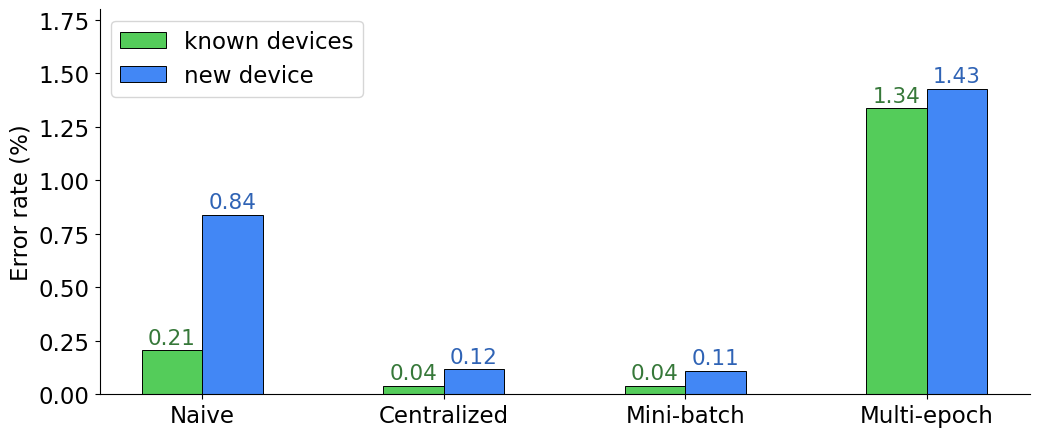

In [53]:
# prop_folder = '0,0787 5rr'
# prop_folder = '0,5 5rr'
prop_folder = '0,5 2rr'
plot_error_rates('test_results/', prop_folder)

These plots are interesting but could be improved with confidence intervals.

In [66]:
def plot_tpr(base_path):
    fig, ax = plt.subplots(figsize=(12, 5))
#     ax.set_title('Average, min and max F1-Scores under the ' +  attack_str + ' attack')
    ax.set_ylabel('TPR (%)')
    ax.set_ylim(0, 100)
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
#     plt.gca().spines['bottom'].set_visible(False)
    
    pos_x = 0
    colors = ['#54cc5a', '#4287f5']
    text_colors = ['#367839', '#2f63b5']
    
    methods = ['naive', 'centralized', 'mini-batch', 'multi-epoch']
    folder = "0,5 2rr/"
    bar_width = 0.5
    sep = 1
    
    for method in methods:
        if method == 'naive':
            current_path = base_path + 'decentralized_autoencoder/' + folder
        elif method == 'mini-batch':
            current_path = base_path + 'decentralized_autoencoder_fedsgd/' + folder
        elif method == 'multi-epoch':
            current_path = base_path + 'decentralized_autoencoder_fedavg/' + folder
        else:
            current_path = base_path + 'centralized_autoencoder/' + folder
        for i, test_set in enumerate(['known devices', 'new device']):
            color = colors[i]
            text_color = text_colors[i]
            if test_set == 'known devices':
                results = get_all_results(current_path)
            else:
                results = get_new_results(current_path)
            
            federated = (method=='mini-batch' or method == 'multi-epoch')
            mean_tpr = get_mean_score(results, 'tpr', federated=federated) * 100
            min_tpr = get_min_score(results, 'tpr', federated=federated) * 100
            max_tpr = get_max_score(results, 'tpr', federated=federated) * 100
            
            bar_height = mean_tpr
            yerr_up = max_tpr - bar_height
            yerr_down = bar_height - min_tpr
            
            if method == 'naive':
                ax.bar(pos_x, height=bar_height, color=color, width=bar_width, lw=0.7, edgecolor='black', label=test_set)
            else:
                ax.bar(pos_x, height=bar_height, color=color, width=bar_width, lw=0.7, edgecolor='black') # yerr=[[yerr_down], [yerr_up]], capsize=11
                
#             ax.errorbar(x=pos_x, y=bar_height, yerr=[[yerr_down], [yerr_up]],
#                         capsize=6, color='black', elinewidth=0, lw=1.0, solid_capstyle='round')
            
            s = percentage_to_text(bar_height, decimals=2)
            if len(s) == 5:
                text_x = pos_x - 0.22
            else:
                text_x = pos_x - 0.25
                
            ax.text(x=text_x, y=bar_height+0.5, s=s, fontsize='13.5', color=text_color)
            
            pos_x += bar_width
        pos_x += sep
        
    ticks = [(.5 * bar_width) + (2 * bar_width + sep) * i  for i in range(0, 4)]
    
    ax.set_xticks(ticks)
#     for tick in ax.xaxis.get_majorticklabels():
#         tick.set_y(-0.05)
    methods = [method.capitalize() for method in methods]
    ax.set_xticklabels(methods)
    ax.legend(loc='right', bbox_to_anchor=(1.28, 0.5))
    plt.show()
    fig.savefig('tpr.pdf', bbox_inches='tight')

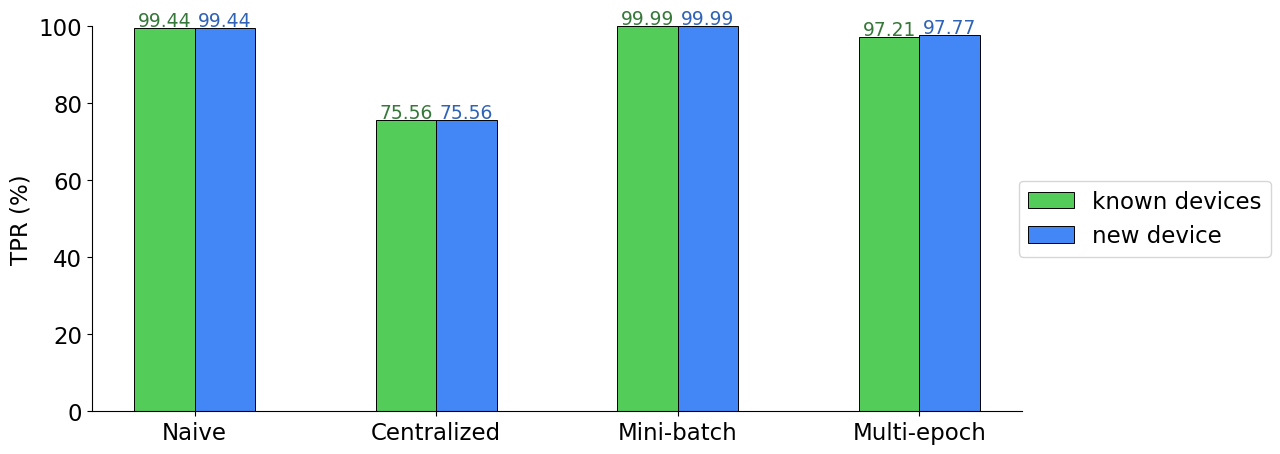

In [68]:
plot_tpr('test_results/')

In [71]:
def plot_tnr(base_path):
    fig, ax = plt.subplots(figsize=(12, 5))
#     ax.set_title('Average, min and max F1-Scores under the ' +  attack_str + ' attack')
    ax.set_ylabel('TNR (%)')
    ax.set_ylim(0, 100)
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
#     plt.gca().spines['bottom'].set_visible(False)
    
    pos_x = 0
    colors = ['#54cc5a', '#4287f5']
    text_colors = ['#367839', '#2f63b5']
    
    methods = ['naive', 'centralized', 'mini-batch', 'multi-epoch']
    folder = "0,5 2rr/"
    bar_width = 0.5
    sep = 1
    
    for method in methods:
        if method == 'naive':
            current_path = base_path + 'decentralized_autoencoder/' + folder
        elif method == 'mini-batch':
            current_path = base_path + 'decentralized_autoencoder_fedsgd/' + folder
        elif method == 'multi-epoch':
            current_path = base_path + 'decentralized_autoencoder_fedavg/' + folder
        else:
            current_path = base_path + 'centralized_autoencoder/' + folder
        for i, test_set in enumerate(['known devices', 'new device']):
            color = colors[i]
            text_color = text_colors[i]
            if test_set == 'known devices':
                results = get_all_results(current_path)
            else:
                results = get_new_results(current_path)
            
            federated = (method=='mini-batch' or method == 'multi-epoch')
            mean_tnr = get_mean_score(results, 'tnr', federated=federated) * 100
            min_tnr = get_min_score(results, 'tnr', federated=federated) * 100
            max_tnr = get_max_score(results, 'tnr', federated=federated) * 100
            
            bar_height = mean_tnr
            yerr_up = max_tnr - bar_height
            yerr_down = bar_height - min_tnr
            
            if method == 'naive':
                ax.bar(pos_x, height=bar_height, color=color, width=bar_width, lw=0.7, edgecolor='black', label=test_set)
            else:
                ax.bar(pos_x, height=bar_height, color=color, width=bar_width, lw=0.7, edgecolor='black') # yerr=[[yerr_down], [yerr_up]], capsize=11
                
#             ax.errorbar(x=pos_x, y=bar_height, yerr=[[yerr_down], [yerr_up]],
#                         capsize=6, color='black', elinewidth=0, lw=1.0, solid_capstyle='round')
            
            s = percentage_to_text(bar_height, decimals=2)
            if len(s) == 5:
                text_x = pos_x - 0.22
            else:
                text_x = pos_x - 0.25
                
            ax.text(x=text_x, y=bar_height+0.5, s=s, fontsize='13.5', color=text_color)
            
            pos_x += bar_width
        pos_x += sep
        
    ticks = [(.5 * bar_width) + (2 * bar_width + sep) * i  for i in range(0, 4)]
    
    ax.set_xticks(ticks)
#     for tick in ax.xaxis.get_majorticklabels():
#         tick.set_y(-0.05)
    methods = [method.capitalize() for method in methods]
    ax.set_xticklabels(methods)
    ax.legend(loc='right', bbox_to_anchor=(1.28, 0.5))
    plt.show()
    fig.savefig('tnr.pdf', bbox_inches='tight')

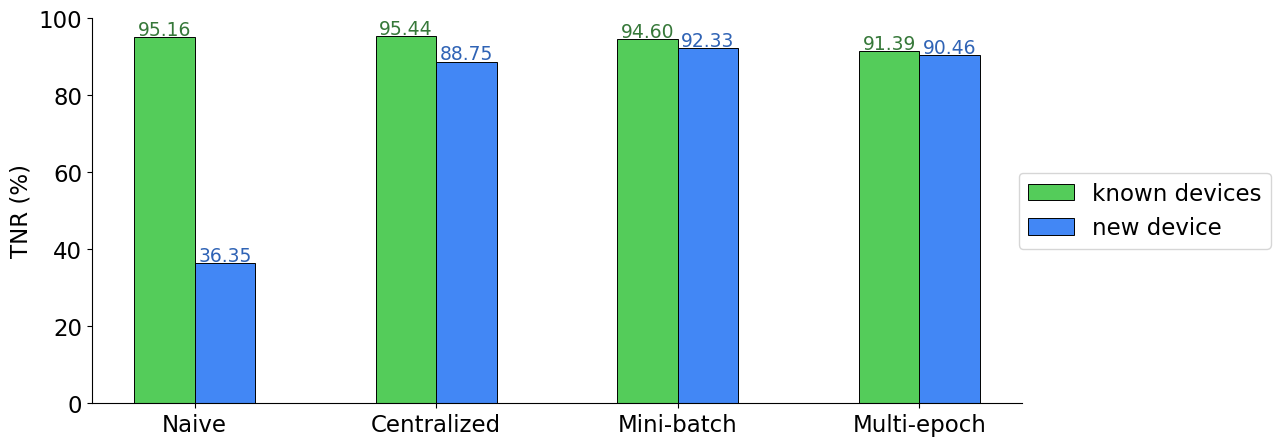

In [72]:
plot_tnr('test_results/')